In [1]:
from src.digital_twin.bess import BatteryEnergyStorageSystem
from src.online_learning.optimizer import Optimizer
from src.online_learning.utils import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
alpha = 0.18 # before wa 0.7,0.3 then 0.1 also 0.175
optimizer_method = 'L-BFGS-B'
#optimizer_method ='BFGS'
#optimizer_method = 'SLSQP' #each param explodes
#optimizer_method = 'nielder_method'
number_of_restarts = 1
bounds = [(0, 1000), (0, 1000), (0, 1000)] # left r0 was: 0.01, right rc: 100, right c: 100
scale_factor = [1e-4, 1e-4, 1e3] #c before: 10^7
batch_size = 6000
options = {
    'maxiter': 1000,   # Increase the maximum number of iterations
    'disp': True,      # Display progress
    'maxls': 50,       # Increase maximum number of line search steps
    'ftol': 1e-12,     # Reduce the step size for line search
    'gtol': 1e-8,       # Gradient norm must be less than this before successful termination
    'approx_grad': True,
}

In [3]:
relative_path_ground = os.path.join('..', '..','..', 'data', 'initialization', 'ground_20.csv')
path_ground = utils.get_absolute_path(relative_path_ground)

# Load Dataframe
df = pd.read_csv(path_ground)
    
#v_real = df['voltage'].values
i_real = df['current'].values
#t_real = df['temperature'].values
time = df['time']
    
# Load YAML:
relative_path_grid = os.path.join('..', '..','..', 'data', 'initialization','grid_parameters')
path_grid = utils.get_absolute_path(relative_path_grid)
grid_parameters = utils.load_from_yaml(path_grid)
    
relative_path_electrical_params = os.path.join('..','..','..','data',
                                                           'initialization','electrical_params')
path_electrical_params = utils.get_absolute_path(relative_path_electrical_params)
electrical_params = utils.load_from_yaml(path_electrical_params)
    
relative_path_thermal_params = os.path.join('..', '..','..', 'data',
                                                           'initialization', 'thermal_params')
path_thermal_params = utils.get_absolute_path(relative_path_thermal_params)
    
thermal_params = utils.load_from_yaml(path_thermal_params)
models_config = [electrical_params, thermal_params]
    
relative_path_battery_options = os.path.join('..', '..','..', 'data',
                                                        'initialization', 'battery_options')
path_battery_options = utils.get_absolute_path(relative_path_battery_options)
    
battery_options = utils.load_from_yaml(path_battery_options)
    
load_var = 'current'
    
battery = BatteryEnergyStorageSystem(
            models_config=models_config,
            battery_options=battery_options,
            input_var=load_var
            )

reset_info = {'electricala_params': electrical_params, 'thermal_params': thermal_params}
battery.reset(reset_info)
    
battery.init({'dissipated_heat' : 0 }) # check if you can remove it
        
elapsed_time = 0
dt = 1            
v_optimizer = list()
temp_optimizer = list()

#battery_results = battery.get_last_results()
optimizer = Optimizer(models_config=models_config, battery_options=battery_options, load_var=load_var,
                      init_info=reset_info, bounds=bounds, scale_factor=scale_factor, options=options)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-new/DT-rse/data/initialization/ground_20.csv'

In [5]:
for k, load in enumerate(i_real):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)

In [33]:
results = battery.build_results_table()
results = results['operations']
v = results['voltage']
v_real = np.array(v)
v_real = v_real[1:len(v_real)]
t = results['temperature']
t_real = np.array(t)
t_real = t_real[1:len(t_real)]

In [34]:
start = 0
elapsed_time = 0
dt = 1            
v_optimizer = list()
temp_optimizer = list()
history_theta = list()
loss_history = list()
gradient_history = list()

In [35]:
for k, load in enumerate(i_real):
        elapsed_time += dt
        battery.t_series.append(elapsed_time)
        dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
        if (k % batch_size == 0 and k != 0): #  or grid.is_changed_cell(soc, temp):

                theta = optimizer.step(i_real=i_real[start:k], v_real=v_real[start:k],
                                        t_real=t_real[start:k],optimizer_method= optimizer_method,
                                        alpha=alpha,dt=dt, number_of_restarts= number_of_restarts)

                history_theta.append(theta)
                start = k
                v_optimizer = v_optimizer + optimizer.get_v_hat()
                #temp_optimizer = temp_optimizer + optimizer.get_t_hat()
                loss_history = loss_history + optimizer.get_loss_history()
                #gradient_history = gradient_history + optimizer.get_gradient_history()
                #battery_results = battery.get_last_results(), do I need this ???

                #self.set_theta_parameters(battery=battery, theta=theta)


restart number : 0

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00046D+02    |proj g|=  1.52187D-01
THETA [492.90332641 859.70175811 198.2151641 ]


At iterate    1    f=  1.99995D+02    |proj g|=  1.52190D-01
the gradient is : [0.14373339070061775, 0.1521660180969775, 0.07929093612801807]
THETA
At iterate    2    f=  1.73612D+02    |proj g|=  2.06987D-01
 [422.83029726 720.68636481 120.28327386]
the gradient is : [0.0, 0.35810889755794045, 0.33128453083008935]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


THETA [440.42415988 707.83504434 109.71273611]


At iterate    3    f=  1.67897D+02    |proj g|=  1.49470D-01
the gradient is : [0.0, 0.23866664946581292, 0.18529985936766022]
THETA [468.95350573 647.31738646  72.49437963]


At iterate    4    f=  1.58938D+02    |proj g|=  1.50325D-01
the gradient is : [0.15043973462525173, 0.1488106960323421, 0.0]
THETA [471.88562351 404.02836855  63.49210435]


At iterate    5    f=  1.26869D+02    |proj g|=  1.99200D-01
the gradient is : [0.19927670251718152, 0.1228405196229687, 0.0]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


THETA [467.70241305 401.44869972  65.11910355]


At iterate    6    f=  1.25676D+02    |proj g|=  1.70398D-01
the gradient is : [0.17045339575361138, 0.12118961763007972, 0.0]
THETA [432.66170818 365.66703901  66.7713397 ]


At iterate    7    f=  1.19226D+02    |proj g|=  1.12239D-01
the gradient is : [0.0, 0.15253957741379054, 0.10074743244103955]
THETA [419.35640229 329.55997102  61.27156598]


At iterate    8    f=  1.15858D+02    |proj g|=  1.06249D-01
the gradient is : [0.0, 0.21102765970226753, 0.20017113939729822]
THETA [377.96944478 137.1346966   22.96067781]


At iterate    9    f=  9.97832D+01    |proj g|=  5.82635D-01
the gradient is : [0.0, 0.16839829726222888, 0.7912425076028738]

  Positive dir derivative in projection 
  Using the backtracking step 



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


THETA
 [382.3509903  137.97990357  10.72534182]

At iterate   10    f=  9.28873D+01    |proj g|=  2.69860D-01
the gradient is : [0.0, 0.0, 0.32802408753696]



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


THETA [382.37991647 138.27059347   9.37604259]


At iterate   11    f=  9.26016D+01    |proj g|=  1.19388D-01
the gradient is : [0.025166086459194045, 0.0, 0.1761354468499121]
THETA [381.95984717 139.04190494   8.12160315]


At iterate   12    f=  9.25063D+01    |proj g|=  7.39604D-02
the gradient is : [0.05521294212940119, 0.0, 0.0]
THETA [380.28710199 141.02117684   8.65048217]


At iterate   13    f=  9.23234D+01    |proj g|=  5.86596D-02
the gradient is : [0.036561554850322864, 0.0, 0.10959856382442011]
THETA [373.75212537 149.07789948   8.60926058]


At iterate   14    f=  9.17854D+01    |proj g|=  2.11520D-01
the gradient is : [0.016966997407052986, 0.0, 0.24924990214003626]
THETA [353.33268918 174.13481996   6.59965969]


At iterate   15    f=  9.04795D+01    |proj g|=  3.65219D-01
the gradient is : [0.019279461582755175, 0.007271070501246867, 0.3652303746548568]
THETA [341.46144133 187.23598623   4.90345543]


At iterate   16    f=  8.98922D+01    |proj g|=  5.93857D-02
the gra


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


THETA [486.12982135 821.72828028  20.19611048]


At iterate    2    f=  2.80107D+02    |proj g|=  2.46056D+00
the gradient is : [0.27140246174894855, 0.22490762603410983, 0.0]
THETA [481.10528785 820.91847691  34.80436193]


At iterate    3    f=  2.75700D+02    |proj g|=  8.52697D-01
the gradient is : [0.0, 0.18737861751105808, 0.8898747296370856]
THETA [481.85953119 820.4064964   31.08360765]


At iterate    4    f=  2.73007D+02    |proj g|=  5.22817D-01
the gradient is : [0.02054709398180421, 0.16128470861076494, 0.5228532643286599]
THETA [479.90580693 817.78067254  24.55332027]


At iterate    5    f=  2.72024D+02    |proj g|=  5.65228D-01
the gradient is : [0.11423052796999399, 0.18903796785707525, 0.0]
THETA
At iterate    6    f=  2.71308D+02    |proj g|=  1.74913D-01
 [479.32273246 817.74950514  27.23441918]
the gradient is : [0.058808535641219344, 0.17469045587858997, 0.03378164592504618]
THETA [471.49312513 811.53838814  25.93790681]


At iterate    7    f=  2.69956D+02    |pr


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3    103      4     0     0   1.688D-01   4.830D+02
  F =   483.02432018730281     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


AttributeError: 'NoneType' object has no attribute 'x'

In [8]:
r0 = []
rc = []
c = []
for theta in history_theta:
    r0.append(theta['r0'])
    rc.append(theta['rc'])
    c.append(theta['c'])
r0 = np.array(r0)
rc = np.array(rc)
c = np.array(c)

In [11]:
history_theta

[]

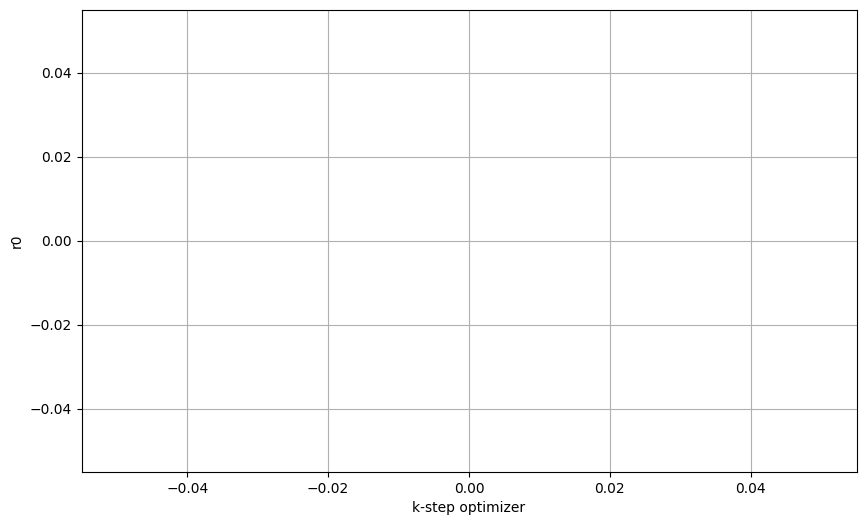

In [9]:
indices = np.arange(len(r0))
plt.figure(figsize=(10, 6))
plt.plot(indices, r0, marker='o', linestyle='-', color='green')
plt.xlabel('k-step optimizer')
plt.ylabel('r0')
plt.grid(True)
plt.show()

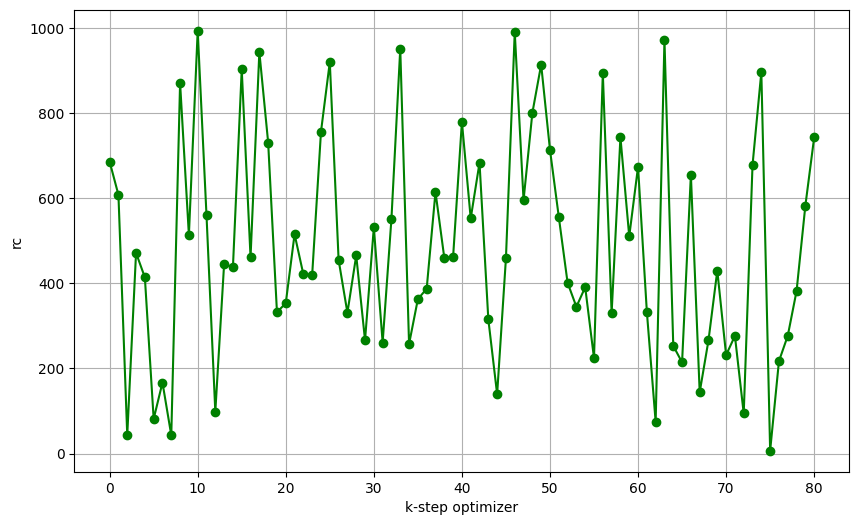

In [12]:
indices = np.arange(len(rc))
plt.figure(figsize=(10, 6))
plt.plot(indices, rc, marker='o', linestyle='-', color='green')
plt.xlabel('k-step optimizer')
plt.ylabel('rc')
plt.grid(True)
plt.show()

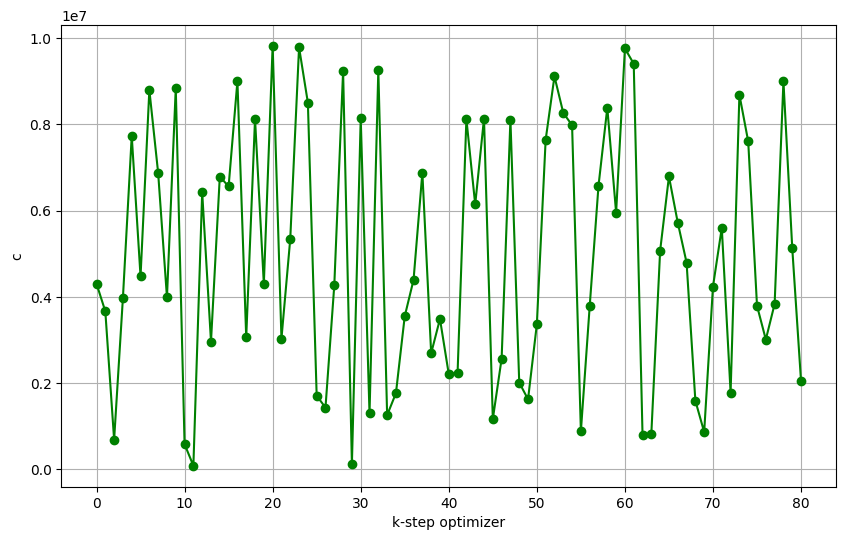

In [13]:
indices = np.arange(len(c))
plt.figure(figsize=(10, 6))
plt.plot(indices, c, marker='o', linestyle='-', color='green')
plt.xlabel('k-step optimizer')
plt.ylabel('c')
plt.grid(True)
plt.show()

In [15]:
print(len(loss_history))
print(len(history_theta))
print(len(v_optimizer))
print(len(temp_optimizer))
print(len(gradient_history))

81
81
32400
32400
4173
